# 17.4 객체 탐지

이번 절에서는 사전 학습된 YOLO(you only look once) 모델을 이용하여 객체 탐지를 실습해 본다. 

ObjectDetector.jl 패키지를 이용하면 YOLO 모델들의 설정 파일과 가중치 파일을 로딩하여 플럭스 계층들로 구성된 YOLO 모델을 얻을 수 있다. 

In [1]:
using Pkg
Pkg.activate("/home/bread/JULIA/chap4")
Pkg.instantiate()

  Activating project at `~/JULIA/chap4`


In [2]:
versioninfo()

Julia Version 1.9.3
Commit bed2cd540a1 (2023-08-24 14:43 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 20 × 12th Gen Intel(R) Core(TM) i7-12700F
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, alderlake)
  Threads: 2 on 20 virtual cores
Environment:
  LD_LIBRARY_PATH = :/usr/local/cuda-11.7/lib64


In [3]:
import ObjectDetector

In [4]:
import FileIO

In [5]:
import Flux

In [6]:
yolo = ObjectDetector.YOLO.v3_COCO()

(1) conv(3,3->32) => (2) conv(3,32->64) => (3) conv(1,64->32) => (4) conv(3,32->64) => 
(5) shortcut(2,4) => (6) conv(3,64->128) => (7) conv(1,128->64) => (8) conv(3,64->128) => 
(9) shortcut(6,8) => (10) conv(1,128->64) => (11) conv(3,64->128) => 
(12) shortcut(9,11) => (13) conv(3,128->256) => (14) conv(1,256->128) => (15) conv(3,128->256) => 
(16) shortcut(13,15) => (17) conv(1,256->128) => (18) conv(3,128->256) => 
(19) shortcut(16,18) => (20) conv(1,256->128) => (21) conv(3,128->256) => 
(22) shortcut(19,21) => (23) conv(1,256->128) => (24) conv(3,128->256) => 
(25) shortcut(22,24) => (26) conv(1,256->128) => (27) conv(3,128->256) => 
(28) shortcut(25,27) => (29) conv(1,256->128) => (30) conv(3,128->256) => 
(31) shortcut(28,30) => (32) conv(1,256->128) => (33) conv(3,128->256) => 
(34) shortcut(31,33) => (35) conv(1,256->128) => (36) conv(3,128->256) => 
(37) shortcut(34,36) => (38) conv(3,256->512) => (39) conv(1,512->256) => (40) conv(3,256->512) => 
(41) shortcut(38,40) => (42

YOLO v3. Trained with DarkNet 0.2.0
WxH: 416x416   channels: 3   batchsize: 1
gridsize: 13x13   classes: 80   thresholds: Detect 0.6. Overlap 0.4

- ObjectDetector.jl 패키지의 YOLO.v3_COCO()를 통해 COCO 데이터 셋으로 사전 학습된 YOLOv3 모델을 얻음

- 80개 클래스 등의 정보를 볼수 있으며,

- v3_COCO 함수 대신 직접 YOLO.yolo(설정 파일 주소, 가중치 파일 주소, 배치 크기) 방식으로 특정 YOLO 모델의 설정 파일과 가중치 파일을 이용할 수도 있다.

- Yolo 객체는 모델 설정값을 가지고 있는 cfg 필드와 

- 플럭스 신경망 계층들로 이루어진 chain 필드를 가짐

In [7]:
yolo.cfg

Dict{Symbol, Any} with 23 entries:
  :batch          => 1
  :channels       => 3
  :yoloversion    => 3
  :max_batches    => 500200
  :steps          => [400000, 450000]
  :height         => 416
  :decay          => 0.0005
  :learning_rate  => 0.001
  :policy         => "steps"
  :scales         => [0.1, 0.1]
  :output         => Any[Dict{Symbol, Any}(:classes=>80, :num=>9, :ignore_thres…
  :hue            => 0.1
  :darknetversion => v"0.2.0"
  :layer2out      => Dict{Any, Any}(5=>2, 56=>19, 35=>12, 55=>19, 60=>21, 30=>1…
  :batchsize      => 1
  :angle          => 0
  :subdivisions   => 1
  :burn_in        => 1000
  :momentum       => 0.9
  :gridsize       => (13, 13)
  :saturation     => 1.5
  :exposure       => 1.5
  :width          => 416

In [8]:
yolo.chain

30-element Vector{Any}:
 Chain(Chain(Conv((3, 3), 3 => 32, pad=1), BatchNorm(32), _act), Chain(Conv((3, 3), 32 => 64, pad=1, stride=2), BatchNorm(64), _act))  # 19_584 parameters, plus 192 non-trainable
 Chain(Chain(Conv((1, 1), 64 => 32), BatchNorm(32), _act), Chain(Conv((3, 3), 32 => 64, pad=1), BatchNorm(64), _act), _add, Chain(Conv((3, 3), 64 => 128, pad=1, stride=2), BatchNorm(128), _act))  # 94_880 parameters, plus 448 non-trainable
 Chain(Chain(Conv((1, 1), 128 => 64), BatchNorm(64), _act), Chain(Conv((3, 3), 64 => 128, pad=1), BatchNorm(128), _act), _add)  # 82_496 parameters, plus 384 non-trainable
 Chain(Chain(Conv((1, 1), 128 => 64), BatchNorm(64), _act), Chain(Conv((3, 3), 64 => 128, pad=1), BatchNorm(128), _act), _add, Chain(Conv((3, 3), 128 => 256, pad=1, stride=2), BatchNorm(256), _act))  # 378_176 parameters, plus 896 non-trainable
 Chain(Chain(Conv((1, 1), 256 => 128), BatchNorm(128), _act), Chain(Conv((3, 3), 128 => 256, pad=1), BatchNorm(256), _act), _add)  # 328_832

## 1. 객체 탐지 

객체 탐지를 적용할 이미지를 다음과 같이 로딩함

In [9]:
pwd()

"/home/bread/JULIA/chap4"

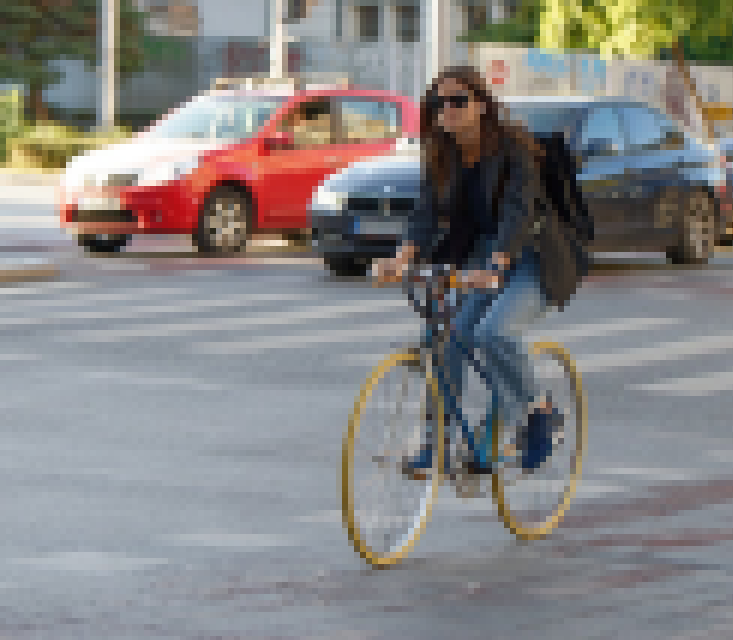

┌ Warning: Output swatches are reduced due to the large size (640×733).
│ Load the ImageShow package for large images.
└ @ Colors ~/.julia/packages/Colors/mIuXl/src/display.jl:159


In [12]:
img = FileIO.load("bicyclist_pixabay.jpg")

In [11]:
readdir()

17-element Vector{String}:
 ".ipynb_checkpoints"
 "IMDB Dataset.csv"
 "Manifest.toml"
 "Project.toml"
 "bicyclist_pixabay.jpg"
 "celeba"
 "ch_16.ipynb"
 "ch_17_1_re.ipynb"
 "ch_17_1_success.ipynb"
 "ch_17_2_success.ipynb"
 "ch_17_3.ipynb"
 "ch_17_4.ipynb"
 "face_dcgan.bson"
 "mnist_mlp.bson"
 "test1"
 "tinyshakespeare.txt"
 "train"

prepareImage 함수를 이용하여 이미지에 대해 모델의 입력 사이즈에 맞게 패딩(padding) 및 사이즈 변경을 실시함

In [13]:
p_img, padding = ObjectDetector.prepareImage(img, yolo);

준비된 이미지에 배치 차원을 추가하고 yolo 모델에 넘기면 객체 탐지 결과를 얻을 수 있음

In [15]:
res = yolo(Flux.batch([p_img]))

89×5 Matrix{Float32}:
 0.0643309    0.40657      0.51427      0.462371     0.704937
 0.17147      0.217871     0.141942     0.42998      0.225984
 0.58221      0.918973     0.780217     0.794347     0.810001
 0.411374     0.44902      0.804677     0.832266     0.487696
 0.99899      0.800017     0.977214     0.998539     0.69339
 1.37842f-5   0.000193515  0.999605     5.28475f-5   0.000425553
 1.09325f-7   0.000279573  0.000751952  0.998326     5.07082f-6
 0.96406      0.882745     3.64557f-5   2.30871f-5   0.000113007
 3.17445f-6   0.00523336   3.79576f-5   3.70332f-5   2.00788f-5
 1.39388f-7   0.000125178  1.40962f-6   2.73603f-7   1.15211f-6
 9.13641f-6   0.000241385  1.25377f-5   6.18095f-6   1.32627f-6
 2.95774f-7   9.39114f-5   7.5508f-6    2.94463f-6   3.93072f-6
 0.0714539    0.045807     1.85486f-5   2.52901f-5   1.05345f-5
 ⋮                                                  
 1.32183f-8   5.76985f-6   3.19891f-6   4.30539f-5   1.62992f-6
 8.37661f-10  1.99784f-5   4.34685f-6 

- 객체 탐지 결과는 (89 x 탐지된 객체 수) 형상의 행렬이다. 

- 행렬의 각 열은 탐지된 객체 정보를 담고 있음

- 각 열에서 (즉 세로 방향으로) 첫번째부터 네번째까지의 원소는 객체 경계 상자(bounding box)의 좌측 상단 시작점의 좌표(x1, y1)과 우측 하단 종료점의 좌표(x2, y2)로서 0에서 1사이의 상대적인 값

- 다섯 번째 원소는 객체 경계 상자가 객체를 포함하고 있을 가능성 및 정확도를 반영하는 신뢰 점수(confidence score)

- 6번째에서 85번째 원소까지는 80개의 클래스에 대해, 탐지된 객체가 해당 클래스에 속하는 지에 대한 확률

- 86번째 원소는 0

- 87번째 원소는 80개의 클래스별 확률 중 가장 큰 확률값

- 88번째 원소는 확률이 가장 큰 클래스의 인덱스

- 마지막 원소인 89번째 값은 해당 객체가 탐지된 이미지의 배치 인덱스

In [33]:
# 사진에 나타내는 객체 경계 상자의 좌상단-우하단 좌표(x1, y1, x2, y2) 및 신뢰 점수(confidence score) 

res[1:5, :]

5×5 Matrix{Float32}:
 0.0643309  0.40657   0.51427   0.462371  0.704937
 0.17147    0.217871  0.141942  0.42998   0.225984
 0.58221    0.918973  0.780217  0.794347  0.810001
 0.411374   0.44902   0.804677  0.832266  0.487696
 0.99899    0.800017  0.977214  0.998539  0.69339

In [32]:
# 1번째 클래스 ~ 5번째 클래스까지의 좌상단-우하단 좌표(x1, y1, x2, y2) 및 신뢰 점수(confidence score) 

res[6:10, :]

5×5 Matrix{Float32}:
 1.37842f-5  0.000193515  0.999605     5.28475f-5  0.000425553
 1.09325f-7  0.000279573  0.000751952  0.998326    5.07082f-6
 0.96406     0.882745     3.64557f-5   2.30871f-5  0.000113007
 3.17445f-6  0.00523336   3.79576f-5   3.70332f-5  2.00788f-5
 1.39388f-7  0.000125178  1.40962f-6   2.73603f-7  1.15211f-6

In [31]:
# 끝의 76번째 클래스 ~ 80번재 클래스까지의 좌상단-우하단 좌표(x1, y1, x2, y2) 및 신뢰 점수(confidence score) 

res[(80) : (6 + 79), :]

6×5 Matrix{Float32}:
 1.45397f-9  5.17056f-6  2.67471f-7  1.53448f-5  2.6347f-6
 5.67891f-9  2.99347f-5  2.70093f-6  1.289f-5    8.21521f-7
 8.51057f-9  1.24332f-5  1.13222f-6  6.53304f-6  4.05059f-6
 2.59253f-9  1.83374f-6  1.95793f-6  2.42245f-7  1.00512f-5
 3.73256f-9  3.14824f-5  4.7953f-7   7.66086f-7  1.63786f-6
 6.30294f-8  3.01911f-5  1.64419f-6  9.89357f-7  2.76151f-7

In [30]:
# 0의 값

res[86:86, :]

1×5 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0

In [35]:
# 87번째 원소는 클래스 중 가장 높은 확률을 가지는 클래스의 정보

res[87:87, :]

1×5 Matrix{Float32}:
 0.96406  0.882745  0.999605  0.998326  0.981608

In [36]:
# 88번째 원소는 확률이 가장 큰 클래스의 인덱스 

res[88:88, :]

1×5 Matrix{Float32}:
 3.0  3.0  1.0  2.0  27.0

In [39]:
# 89번째 원소는 해당 객체가 탐지된 이미지의 배치 인덱스

res[89:89, :]

1×5 Matrix{Float32}:
 1.0  1.0  1.0  1.0  1.0

## 2. 탐지 결과 그리기

- 탐지된 객체들의 경계 상자와 클래스, 상자 신뢰도를 이미지에 그려봄

- ObjectDetector.jl 패키지에서 기본으로 제공하는 경계 상자 드로잉 함수(drawBoxes)는 선 굵기나 색깔 등을 컨트롤 할 수 없고, 

- 클래스 정보를 캡션으로 보여주지 않기 때문에 해당 함수를 참고하여 직접 탐지 결과를 그리는 함수를 작성 

In [40]:
classes = ["person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat", "traffic light", "fire hydrant", "stop sign", 
    "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", 
    "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", 
    "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", 
    "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch", "potted plant", "bed", "dining table", "toilet", "tv", "laptop", 
    "mouse", "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", 
    "teddy bear", "hair drier", "toothbrush"];

In [41]:
import Colors
import SimpleDraw as SD

function drawDetection(img, model, padding, results)
    drawDetection!(copy(img), model, padding, results)
end

drawDetection (generic function with 1 method)

In [45]:
function drawDetection!(img, model, padding, results)
    imgratio = size(img, 2) / size(img, 1)
    modelratio = model.cfg[:width] / model.cfg[:height]
    x1i, y1i, x2i, y2i = [ 1, 2, 3, 4 ]
    if modelratio > imgratio
        h, w = size(img, 1) .* (1, modelratio)
    else
        h, w = size(img, 2) ./ (modelratio, 1)
    end
    
    length(results) == 0 && return img
    
    for i in 1:size(results, 2)
        bbox = results[1:4, i] .- padding # bounding box (경계 상자)
        x1, y1 = round(Int, bbox[x1i] * w), round(Int, bbox[y1i] *h)
        rect_p0 = SD.Point(y1, x1)
        rect_h = round(Int, (bbox[y2i] - bbox[y1i]) * h)
        rect_w = round(Int, (bbox[x2i] - bbox[x1i]) * w)
        shape = SD.ThickRectangle(rect_p0, rect_h, rect_w, 2)
        SD.draw!(img, shape, Colors.RGB(1, 1, 1))
        
        class = classes[Int(results[end-1, i])]
        conf = round(results[5, i]; digits = 4)
        x1, y1 = round(Int, bbox[x1i] * w), round(Int, bbox[y1i] * h)
        txt_p0 = SD.Point(y1 + 3, x1 + 3) 
        txt = SD.TextLine(txt_p0, "$class $conf", SD.TERMINUS_16_8)
        SD.draw!(img, txt, Colors.RGB(1, 1, 1))
    end
    
    return img
    
end    

drawDetection! (generic function with 1 method)

- 이 함수는 객체 경계 상자의 좌표에 대해, prepareImage 함수에서 원본 사진을 모델의 입력 사이즈에 맞게 사이즈 변경하고 패딩을 적용한 과정을 역으로 수행함

- 원본 이미지에 대해 계산된 경계 상자의 좌표를 이용하여 상자를 그리고 클래스 및 상자 신뢰 점수도 텍스트로 그려준다. 

- 다음은 앞에서 사용한 그림 파일에 대해 객체를 탐지한 결과 이미지이다.

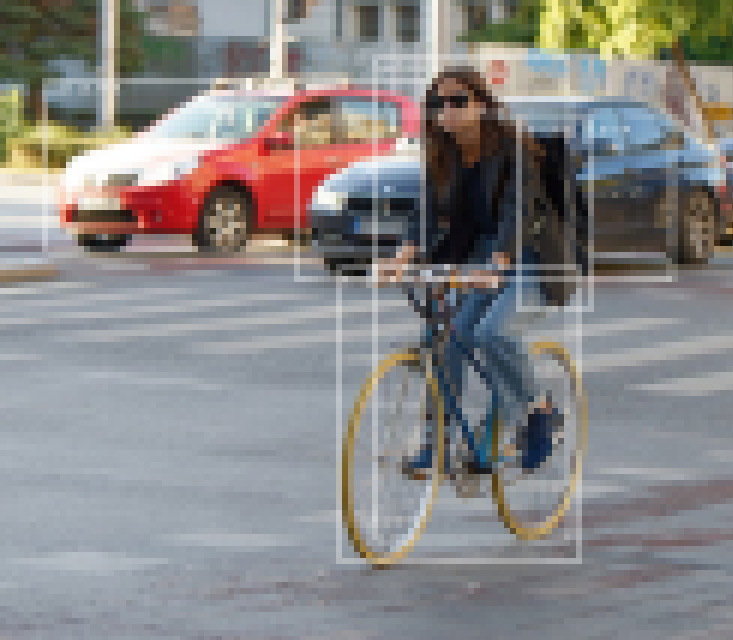

┌ Warning: Output swatches are reduced due to the large size (640×733).
│ Load the ImageShow package for large images.
└ @ Colors ~/.julia/packages/Colors/mIuXl/src/display.jl:159


In [46]:
imgBoxes = drawDetection(img, yolo, padding, res)

In [47]:
FileIO.save("bicyclist_boxed_result.png", imgBoxes)

In [49]:
using ImageShow

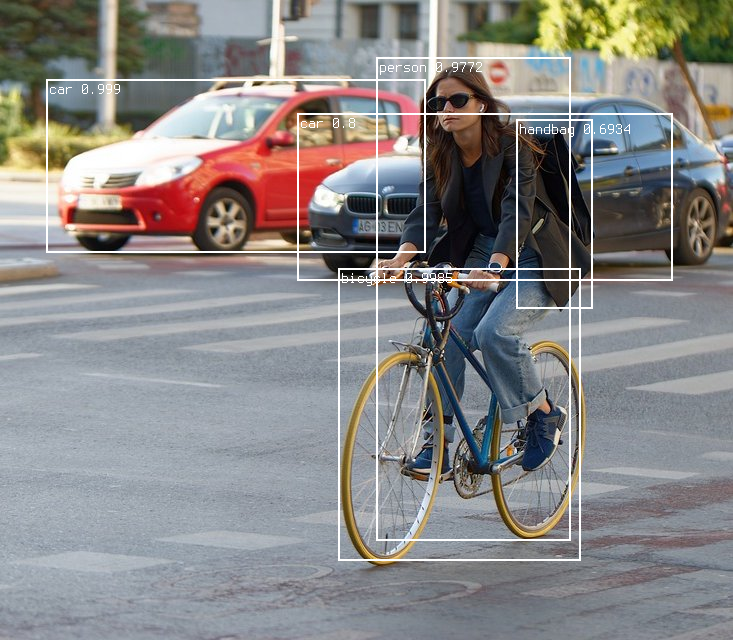

In [51]:
# ImageShow 패키지를 이용하여 해상도를 높인 상태로 불러옴

imgBoxes = drawDetection(img, yolo, padding, res)